In [2]:
import itertools
import numpy as np
import math
import timeit
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import newton
import random

class SIR_parameter_estimation_simulator:
    
    def beta(self, R0, t_I):
        
        return R0 / t_I
    
    def generate_true_ages_of_infection(self, N_v, R0, t_I):
        
        # Generates N_p ages-of-infection from an infected population that is in the exponential phase of the
        # epidemic   
        
        return np.random.exponential(t_I / R0, N_v)
    
    def generate_viral_load(self, tau, tau_max, tau_half, v_0 = 1, v_max = 10**6):
        
        # Takes a person with age-of-infection tau who was infected during the exponential rise of an SIR 
        # epidemic and returns their viral load
    
        # age_of_infection_of_viral_max is the age-of-infection that someone achieves their max viral load v_max
        # viral_half_life is the time after tau_max that it takes the viral load to decay to half of v_max
        
        alpha = (1 / tau_max) * math.log(v_max / v_0)
        Phi = math.log(2) / (tau_half)
        
        if tau == tau_max:
            
            return [v_max]
        
        elif 0 <= tau <= tau_max:
            
            return v_0 * np.exp(alpha * tau)
        
        elif tau > tau_max:
            
            return v_max * np.exp(-Phi * (tau - tau_max))

    def generate_set_viral_loads(self, R0, N_v, t_I, tau_max, tau_half, v_max = 10 ** 6):
        
        # Generates a set of randomly sampled viral loads for the parameters entered
        
        return [self.generate_viral_load(tau, tau_max, tau_half, 1, v_max) for tau in self.generate_true_ages_of_infection(N_v, R0, t_I)]
        
    def V(self, v, rho, tau_max, tau_half, v_max = 10 ** 6):
        
        alpha = np.log(v_max) / tau_max
        Phi = np.log(2) / tau_half
        
        if 0 < v < 1:
            
            return rho / Phi * np.exp(-rho * tau_max) * v_max ** (-rho / Phi) * v ** (rho / Phi - 1)
        
        elif 1 <= v <= v_max:
            
            return rho / alpha * v ** (-rho / alpha - 1) + rho / Phi * np.exp(-rho * tau_max) * v_max ** (-rho / Phi) * v ** (rho / Phi - 1)
        
        else:
            
            return None

    def d_V_d_rho(self, v, rho, tau_max, tau_half, v_max = 10 ** 6):
        
        alpha = np.log(v_max) / tau_max
        Phi = np.log(2) / tau_half
        
        if 0 < v < 1:
            
            return 1 / Phi * np.exp(-rho * tau_max) * v_max ** (-rho / Phi) * v ** (rho / Phi - 1) * (1 - rho * (tau_max + 1 / Phi * np.log(v_max / v)))
        
        elif 1 <= v <= v_max:
            
            return 1 / alpha * v **(-rho / alpha - 1) * (1 - rho * np.log(v) / alpha) + 1 / Phi * np.exp(-rho * tau_max) * v_max ** (-rho / Phi) * v ** (rho / Phi - 1) * (1 - rho * (tau_max + 1 / Phi * np.log(v_max / v)))
        
        else:
            
            return None
        
    def d_log_likelihood_d_rho(self, rho, viral_loads, tau_max, tau_half, v_max = 10 ** 6):
        
        return sum([(1 / self.V(v, rho, tau_max, tau_half, v_max)) * self.d_V_d_rho(v, rho, tau_max, tau_half, v_max) for v in viral_loads])

    def generate_rho_estimate(self, viral_loads, tau_max, tau_half, x0, v_max =  10 ** 6):
        
        return newton(self.d_log_likelihood_d_rho, x0 = x0, args = (viral_loads, tau_max, tau_half, v_max))
    
    def generate_visual_rho_estimate(self, viral_loads, tau_max, tau_half, v_max = 10 ** 6):
        
        N_v = len(viral_loads)
        
        rho_linspace = np.linspace(0.01, 10, 1000)
        
        likelihood_product_vals = []
        log_likelihood_sum_vals = []
        d_log_likelihood_sum_d_rho_vals = []
        
        rho_estimate = self.generate_rho_estimate(viral_loads, tau_max, tau_half, 0.2, v_max)
        
        for rho in rho_linspace:
            
            likelihood_product = 1
            log_likelihood_sum = 0
            d_log_likelihood_sum_d_rho = 0
            
            for v in viral_loads:
            
                likelihood_product *= self.V(v, rho, tau_max, tau_half, v_max)
                log_likelihood_sum += np.log(self.V(v, rho, tau_max, tau_half, v_max))
                d_log_likelihood_sum_d_rho += 1 / self.V(v, rho, tau_max, tau_half, v_max) * self.d_V_d_rho(v, rho ,tau_max, tau_half, v_max)
                
            likelihood_product_vals.append(likelihood_product)
            log_likelihood_sum_vals.append(log_likelihood_sum) 
            d_log_likelihood_sum_d_rho_vals.append(d_log_likelihood_sum_d_rho)
            
        fig, axes = plt.subplots(2, 2, figsize = (8, 6))
        
        fig.suptitle(r'$\hat{\rho}$ = ' + str(round(rho_estimate, 1)))
        
        axes[0, 0].plot(rho_linspace, likelihood_product_vals)
        axes[0, 0].set_title("Likelihood")
        
        axes[0, 1].plot(rho_linspace, log_likelihood_sum_vals)
        axes[0, 1].set_title("Log likelihood")
        
        axes[1, 0].plot(rho_linspace, d_log_likelihood_sum_d_rho_vals)
        axes[1, 0].set_title(r"$\frac{d}{d \rho}$ log likelihood")
        
        plt.tight_layout()
  
    def generate_data_rho_estimates(self, N_v, num_iterations, R0, t_I, tau_max, tau_half, v_max = 10 ** 6, x0 = 0.2):
        
        data_set = []
        
        for i in range(num_iterations):
            
            viral_loads = [SIR.generate_viral_load(tau, tau_max, tau_half) for tau in SIR.generate_true_ages_of_infection(N_v, R0, t_I)]
            
            rho_estimate = newton(self.d_log_likelihood_d_rho, x0, args=(viral_loads, tau_max, tau_half, v_max))
            data_set.append(rho_estimate)
        
        return data_set
            
    def generate_box_plots_by_N_v_values(self, N_v_vals, num_iterations, R0, t_I, tau_max, tau_half, x0 = 0.2, savefig_filename = False, v_max = 10 **6):
        
        rho_estimate_data_by_N_v = []
        
        for N_v in N_v_vals:
            
            rho_estimate_data = []
            
            for i in range(num_iterations):
                
                viral_loads = self.generate_set_viral_loads(R0, N_v, t_I, tau_max, tau_half, v_max)
                
                rho_estimate_data.append(self.generate_rho_estimate(viral_loads, tau_max, tau_half, x0, v_max))
                
            rho_estimate_data_by_N_v.append(rho_estimate_data)
            
        fig, ax = plt.subplots()
        
        ax.boxplot(rho_estimate_data_by_N_v)

        ax.set_xticklabels( [str(N_v_val) for N_v_val in N_v_vals])
        ax.set_xlabel(r'$N_v$')
        
        ax.axhline(y = R0/t_I)
        
        ax.set_ylabel(r'$\hat{\rho}$', rotation = 0)
        
        if savefig_filename != False:
            
            fig.savefig('images/' + savefig_filename, dpi = 200)
      
    def run_checks(self):
        
        R0 = np.random.uniform(1.1, 5)
        t_I = np.random.uniform(1, 10)
        rho = R0 / t_I
        
        tau_max = np.random.uniform(1, 5)
        tau_half = np.random.uniform(1, 5)
        
        return quad(self.V, 0.2, 10 ** 6, args = (rho, tau_max, tau_half))
        
SIR = SIR_parameter_estimation_simulator()
SIR.run_checks()

(0.9999784522894409, 1.3404994891885735e-09)

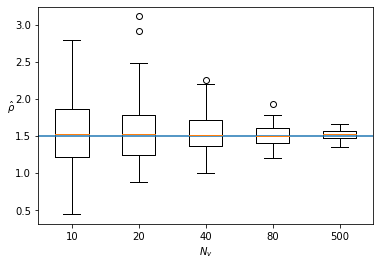

In [5]:
# Generate boxplots of the estimates of rho by N_v values

N_v_vals = [10, 20, 40, 80, 500]
num_iterations = 100

R0 = 3
t_I = 2
tau_max = 2
tau_half = 3
x0 = 0.5
v_max = 10 ** 6
savefig_filename = False
#savefig_filename = 'boxplot_rho_estimates.png'

SIR.generate_box_plots_by_N_v_values(N_v_vals, num_iterations, R0, t_I, tau_max, tau_half, x0, savefig_filename, v_max)


rho = 0.75


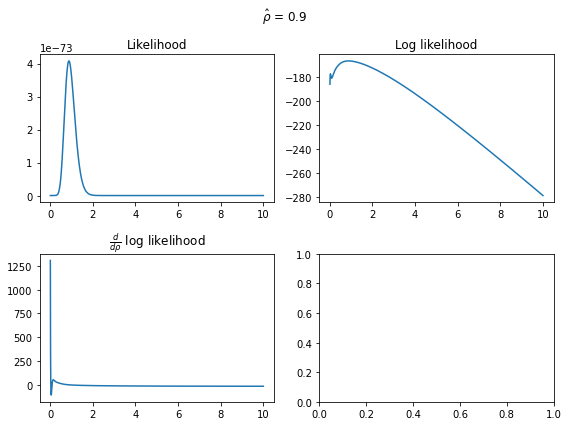

In [4]:
# Plot our likelihood, log likelihhod and derivative of our log likelihood functions

N_v = 20

R0 = 3#random.uniform(1.1, 5)
t_I = 4#random.uniform(0.5, 5)
tau_max = 2
tau_half = 3

viral_loads = [SIR.generate_viral_load(tau, tau_max, tau_half) for tau in SIR.generate_true_ages_of_infection(N_v, R0, t_I)]


SIR.generate_visual_rho_estimate(viral_loads, tau_max, tau_half)
print("rho = " + str(R0 / t_I))

In [25]:
# Generate data set of rho estimates for given parameters

N_v = 50
num_iterations = 10

R0 = 3
t_I = 1
rho = R0 / t_I

tau_max = 2
tau_half = 3

print("True rho = " + str(rho))
sum(SIR.generate_data_rho_estimates(N_v, num_iterations, R0, t_I, tau_max, tau_half))/num_iterations

True rho = 3.0


3.0738035741148293

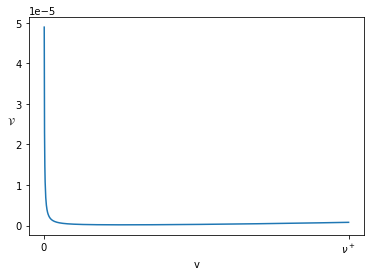

In [12]:
# Plot our viral distribution

#R0 = 3
R0 = random.uniform(1.1, 5)
#t_I = 2
t_I = random.uniform(.5, 5)

rho = R0 / t_I
tau_max = 2
tau_half = 3
v_max = 10**6

v_linspace = np.linspace(0, v_max, 1000)

fig, ax = plt.subplots()

ax.plot(v_linspace, [SIR.V(v, rho, tau_max, tau_half, v_max = v_max) for v in v_linspace])
ax.set_xlabel("v")
ax.set_xticks([0, v_max])
ax.set_xticklabels([0, r'$\nu^+$'])
ax.set_ylabel(r'$\mathcal{V}$', rotation = 0)

fig.savefig("V_distribution_plot.png", dpi = 400)